In [ ]:
pip install pybaseball scikit-learn pandas numpy

In [ ]:
import pandas as pd
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup

# 1. Find Aroldis Chapman's MLB ID
player_info = playerid_lookup('chapman', 'aroldis')
chapman_id = player_info['key_mlbam'].values[0]

# 2. Fetch data from 2023 to 2025 (to get enough training data)
# Note: In your timeline, ensure the end_date covers the 2025 season
df = statcast_pitcher('2023-04-01', '2025-10-01', player_id=chapman_id)

print(f"Data fetched: {len(df)} pitches")

Gathering player lookup table. This may take a moment.
Gathering Player Data
Data fetched: 3436 pitches


In [ ]:
# Select relevant features for the Game State
features = [
    'inning',           # The core question: 8th vs 9th
    'balls', 'strikes', # Count
    'outs_when_up',     # Urgency
    'on_3b', 'on_2b', 'on_1b', # Runners (will need to convert to binary)
    'score_differential', # Is it a save situation?
    'stand'             # Batter handedness (L vs R)
]

# Clean the data
data = df.copy()

# 1. Handle Runners: Statcast uses IDs for runners; we just want to know if someone is there.
data['on_1b'] = data['on_1b'].apply(lambda x: 1 if x > 0 else 0)
data['on_2b'] = data['on_2b'].apply(lambda x: 1 if x > 0 else 0)
data['on_3b'] = data['on_3b'].apply(lambda x: 1 if x > 0 else 0)

# 2. Calculate Score Differential (Red Sox score - Opponent score)
# Note: Statcast data is from pitcher's perspective.
# If Chapman is pitching, 'bat_score' is opponent, 'fld_score' is Chapman's team.
data['score_differential'] = data['fld_score'] - data['bat_score']

# 3. Encode Batter Hand (R=0, L=1)
data['is_lefty_batter'] = data['stand'].apply(lambda x: 1 if x == 'L' else 0)

# 4. Define Target Variable: Did the team WIN this game?
# This info is sometimes in 'game_pk' lookups, but for a pitch-level model,
# let's predict "Run Prevented" or use 'events' to predict "Out".
# SIMPLER APPROACH: Predict if the At-Bat resulted in an Out.
# 'events' column has values like 'strikeout', 'single', etc.
out_events = ['strikeout', 'field_out', 'grounded_into_double_play', 'force_out', 'pop_out']
data['is_out'] = data['events'].apply(lambda x: 1 if x in out_events else 0)

# Drop rows where 'events' is null (intermediate pitches) if you want to predict AB outcome
data_ab = data.dropna(subset=['events'])

# Final Feature Set
X = data_ab[['inning', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b', 'score_differential', 'is_lefty_batter']]
y = data_ab['is_out']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train
rf_model.fit(X_train, y_train)

# Evaluate
preds = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))

Accuracy: 0.6130952380952381


Predicted Success Probability in 8th: 84.35%
Predicted Success Probability in 9th: 88.57%


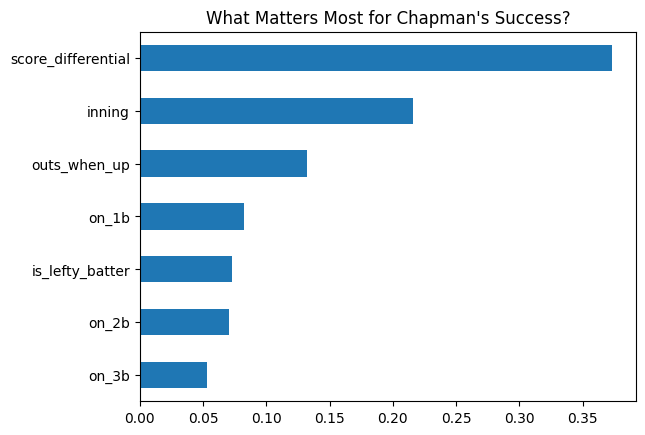

In [ ]:
import numpy as np

# Create a hypothetical "High Leverage" scenario
# Example: Tie game, runner on 2nd, 1 out, Right-handed batter
scenario_8th = pd.DataFrame({
    'inning': [8],
    'outs_when_up': [1],
    'on_1b': [0],
    'on_2b': [1],
    'on_3b': [0],
    'score_differential': [0],
    'is_lefty_batter': [0]
})

scenario_9th = scenario_8th.copy()
scenario_9th['inning'] = 9

# Predict Probability of Success (Getting an Out)
prob_8th = rf_model.predict_proba(scenario_8th)[0][1] # [0][1] is probability of class 1 (Out)
prob_9th = rf_model.predict_proba(scenario_9th)[0][1]

print(f"Predicted Success Probability in 8th: {prob_8th:.2%}")
print(f"Predicted Success Probability in 9th: {prob_9th:.2%}")

# Feature Importance
import matplotlib.pyplot as plt
import pandas as pd

importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh')
plt.title("What Matters Most for Chapman's Success?")
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define the possible "Crisis" scenarios in the 8th Inning
# We focus on close games (Tie or +1 lead)
scenarios = []
for on_1b in [0, 1]:
    for on_2b in [0, 1]:
        for on_3b in [0, 1]:
            for outs in [0, 1, 2]:
                scenarios.append({
                    'inning': 8,
                    'outs_when_up': outs,
                    'on_1b': on_1b,
                    'on_2b': on_2b,
                    'on_3b': on_3b,
                    'score_differential': 1, # Red Sox leading by 1 (Save situation)
                    'is_lefty_batter': 1     # Let's assume a Lefty (often hardest to get out)
                })

df_scenarios = pd.DataFrame(scenarios)

# 2. Predict Chapman's Success for each scenario
probs = rf_model.predict_proba(df_scenarios)
df_scenarios['success_prob'] = probs[:, 1] # Probability of getting an Out

# 3. Create a descriptive label for the runners
def get_runner_state(row):
    bases = []
    if row['on_1b']: bases.append("1st")
    if row['on_2b']: bases.append("2nd")
    if row['on_3b']: bases.append("3rd")
    return ", ".join(bases) if bases else "Clean Bases"

df_scenarios['runner_state'] = df_scenarios.apply(get_runner_state, axis=1)

# 4. Filter for "High Value" Scenarios
# (Where probability is high despite runners being on)
fireman_spots = df_scenarios[df_scenarios['runner_state'] != "Clean Bases"].sort_values('success_prob', ascending=False)

print("Top 5 'Fireman' Scenarios for Chapman in the 8th:")
print(fireman_spots[['outs_when_up', 'runner_state', 'success_prob']].head(5))

Top 5 'Fireman' Scenarios for Chapman in the 8th:
    outs_when_up   runner_state  success_prob
12             0            1st      0.881966
20             2       1st, 2nd      0.853813
14             2            1st      0.844737
8              2            2nd      0.834743
22             1  1st, 2nd, 3rd      0.781905


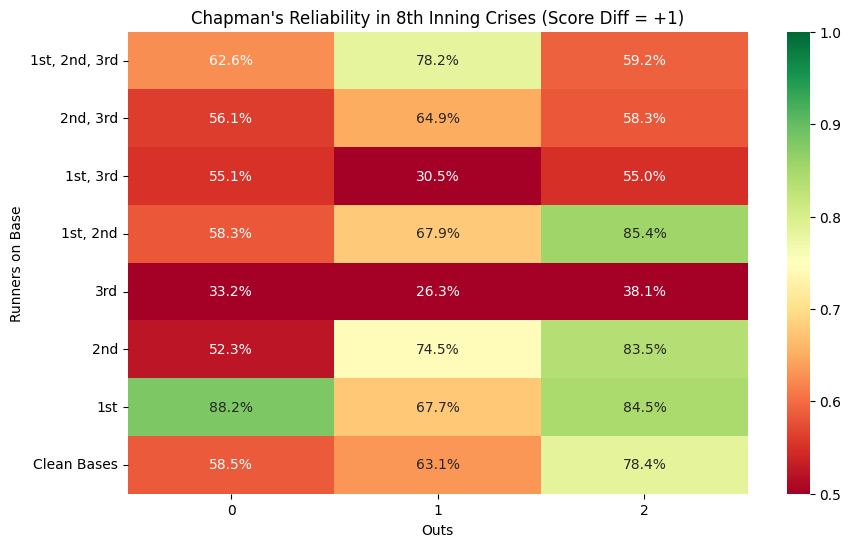

In [ ]:
# Pivot data for Heatmap: Runner State vs. Outs
heatmap_data = df_scenarios.pivot(index='runner_state', columns='outs_when_up', values='success_prob')

# Sort index to put "Bases Loaded" at the top (highest pressure)
runner_order = ['1st, 2nd, 3rd', '2nd, 3rd', '1st, 3rd', '1st, 2nd', '3rd', '2nd', '1st', 'Clean Bases']
heatmap_data = heatmap_data.reindex(runner_order)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1%", cmap="RdYlGn", vmin=0.5, vmax=1.0)
plt.title("Chapman's Reliability in 8th Inning Crises (Score Diff = +1)")
plt.ylabel("Runners on Base")
plt.xlabel("Outs")
plt.show()

In [ ]:
import pandas as pd
from pybaseball import pitching_stats, playerid_lookup, statcast_pitcher
import time

# 1. Get Top 20 Closers (Set qual=30 to include relievers with >30 IP)
print("Fetching top closer list...")
# qual=30 ensures we get relievers; default is qualified starters only.
stats_2024 = pitching_stats(2024, qual=30)
top_closers = stats_2024.sort_values('SV', ascending=False).head(20)[['Name', 'SV', 'Team']]

print("Corrected Top 5 Closers found:")
print(top_closers[['Name', 'SV']].head(5))

# 2. Fetch Data (Same logic as before, but now with the right players)
all_data = []

for index, row in top_closers.iterrows():
    name = row['Name']
    print(f"Fetching data for: {name} ({row['SV']} Saves)...")

    try:
        # Split name for lookup (e.g., "Emmanuel Clase" -> "Clase", "Emmanuel")
        # specific handling for names with suffixes if needed, but usually this works
        first, last = name.split(' ', 1)
        player_ids = playerid_lookup(last, first)

        if not player_ids.empty:
            mlb_id = player_ids['key_mlbam'].values[0]

            # Fetch 2023-2025 Data
            player_data = statcast_pitcher('2023-04-01', '2025-10-01', player_id=mlb_id)
            player_data['pitcher_name'] = name
            all_data.append(player_data)
        else:
            print(f"Could not find ID for {name}")

    except Exception as e:
        print(f"Error fetching {name}: {e}")

    time.sleep(2) # Respect rate limits

if all_data:
    df_all = pd.concat(all_data)
    print(f"Total Pitches Fetched: {len(df_all)}")
else:
    print("No data fetched. Check your connection or player names.")

Fetching top closer list...
Corrected Top 5 Closers found:
                Name  SV
22      Ryan Helsley  49
0     Emmanuel Clase  47
197    Kyle Finnegan  38
62     Robert Suarez  36
16   Raisel Iglesias  34
Fetching data for: Ryan Helsley (49 Saves)...
Gathering Player Data
Fetching data for: Emmanuel Clase (47 Saves)...
Gathering Player Data
Fetching data for: Kyle Finnegan (38 Saves)...
Gathering Player Data
Fetching data for: Robert Suarez (36 Saves)...
Gathering Player Data
Fetching data for: Raisel Iglesias (34 Saves)...
Gathering Player Data
Fetching data for: Josh Hader (34 Saves)...
Gathering Player Data
Fetching data for: Kirby Yates (33 Saves)...
Gathering Player Data
Fetching data for: Clay Holmes (30 Saves)...
Gathering Player Data
Fetching data for: Jason Foley (28 Saves)...
Gathering Player Data
Fetching data for: Mason Miller (28 Saves)...
Gathering Player Data
Fetching data for: Alexis Diaz (28 Saves)...
Could not find ID for Alexis Diaz
Fetching data for: Kenley Jans

Processing data...
Training Random Forest on Elite Closer Data...
Model Accuracy: 68.61%
Simulating 8th Inning 'Fireman' Scenarios...


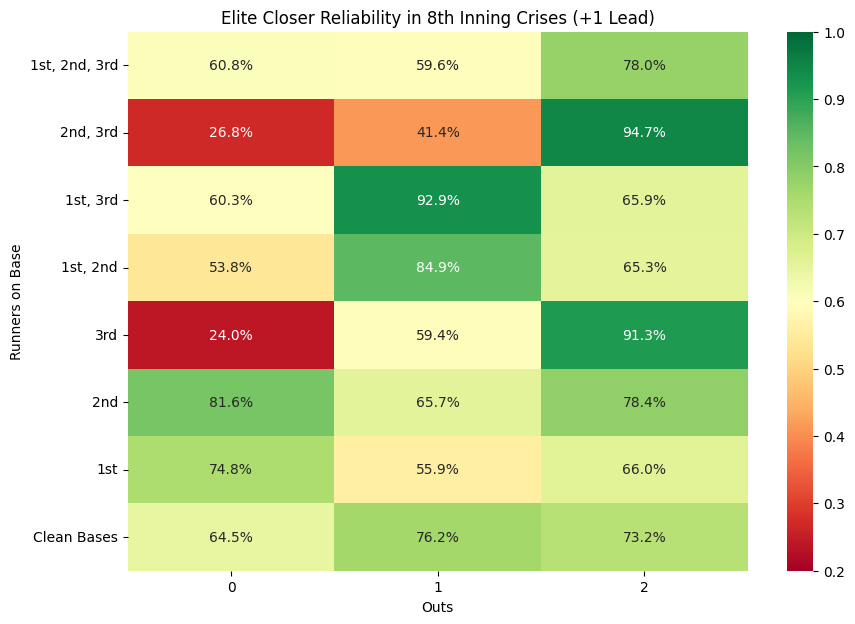

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- 1. FEATURE ENGINEERING ---
print("Processing data...")
data = df_all.copy()

# Handle Runners (Convert IDs to 1/0 boolean)
data['on_1b'] = data['on_1b'].fillna(0).apply(lambda x: 1 if x > 0 else 0)
data['on_2b'] = data['on_2b'].fillna(0).apply(lambda x: 1 if x > 0 else 0)
data['on_3b'] = data['on_3b'].fillna(0).apply(lambda x: 1 if x > 0 else 0)

# Calculate Score Differential (Fielding Team Score - Batting Team Score)
data['score_differential'] = data['fld_score'] - data['bat_score']

# Target Variable: Did the At-Bat result in an Out?
# We include all common "out" events
out_events = [
    'strikeout', 'field_out', 'grounded_into_double_play', 'force_out',
    'pop_out', 'double_play', 'strikeout_double_play', 'sac_fly', 'sac_bunt'
]
data['is_out'] = data['events'].apply(lambda x: 1 if x in out_events else 0)

# Filter: Keep only rows where an At-Bat ended (non-null events)
data_ab = data.dropna(subset=['events'])

# Select Features for the "Fireman" Model
features = ['inning', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b', 'score_differential']
X = data_ab[features]
y = data_ab['is_out']

# --- 2. TRAIN THE RANDOM FOREST ---
print("Training Random Forest on Elite Closer Data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
rf_model.fit(X_train, y_train)

# Quick Accuracy Check
print(f"Model Accuracy: {accuracy_score(y_test, rf_model.predict(X_test)):.2%}")

# --- 3. SIMULATE 8TH INNING CRISIS SCENARIOS ---
print("Simulating 8th Inning 'Fireman' Scenarios...")

# Create every combination of runners and outs for an 8th inning, 1-run game
scenarios = []
for on_1b in [0, 1]:
    for on_2b in [0, 1]:
        for on_3b in [0, 1]:
            for outs in [0, 1, 2]:
                scenarios.append({
                    'inning': 8,
                    'outs_when_up': outs,
                    'on_1b': on_1b,
                    'on_2b': on_2b,
                    'on_3b': on_3b,
                    'score_differential': 1
                })

df_scenarios = pd.DataFrame(scenarios)

# Predict Success Probability (Probability of getting an OUT)
probs = rf_model.predict_proba(df_scenarios)
df_scenarios['success_prob'] = probs[:, 1]

# Create readable labels for the heatmap
def get_runner_state(row):
    bases = []
    if row['on_1b']: bases.append("1st")
    if row['on_2b']: bases.append("2nd")
    if row['on_3b']: bases.append("3rd")
    return ", ".join(bases) if bases else "Clean Bases"

df_scenarios['runner_state'] = df_scenarios.apply(get_runner_state, axis=1)

# --- 4. GENERATE THE HEATMAP ---
# Pivot data: Rows = Runners, Columns = Outs, Values = Probability
heatmap_data = df_scenarios.pivot(index='runner_state', columns='outs_when_up', values='success_prob')

# Sort rows by pressure (Clean bases at bottom, Bases loaded at top)
runner_order = ['1st, 2nd, 3rd', '2nd, 3rd', '1st, 3rd', '1st, 2nd', '3rd', '2nd', '1st', 'Clean Bases']
heatmap_data = heatmap_data.reindex(runner_order)

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=True, fmt=".1%", cmap="RdYlGn", vmin=0.2, vmax=1.0)
plt.title("Elite Closer Reliability in 8th Inning Crises (+1 Lead)")
plt.ylabel("Runners on Base")
plt.xlabel("Outs")
plt.show()

In [ ]:
import pandas as pd
import numpy as np

print("Calculating Run Expectancy Targets...")

# 1. 確保數據按照時間順序排列 (比賽ID -> 局數 -> 打席編號 -> 球數編號)
df_clean = df_all.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number']).copy()

# 2. 計算每個半局的「最終得分」
# 我們按照 (game_pk, inning, top_bottom) 分組，找出該半局結束時對手的最高得分
# 'post_bat_score' 是該打席結束後的進攻方分數
inning_end_scores = df_clean.groupby(['game_pk', 'inning', 'inning_topbot'])['post_bat_score'].transform('max')

# 3. 計算「剩餘失分」 (Runs Scored Rest of Inning)
# 邏輯：半局最終分數 - 當下進攻方分數
df_clean['runs_rest_of_inning'] = inning_end_scores - df_clean['bat_score']

# 4. 定義新的目標變數：is_fireman_success
# 如果剩餘失分 = 0，代表投手成功守住不失分 (Success = 1)
# 如果剩餘失分 > 0，代表後來有掉分 (Fail = 0)
df_clean['is_fireman_success'] = df_clean['runs_rest_of_inning'].apply(lambda x: 1 if x == 0 else 0)

# 檢查一下數據分佈
print("Success Rate (0 Runs Allowed) per Situation:")
print(df_clean['is_fireman_success'].value_counts(normalize=True))

Calculating Run Expectancy Targets...
Success Rate (0 Runs Allowed) per Situation:
is_fireman_success
1    0.788009
0    0.211991
Name: proportion, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- 特徵工程 ---
# 處理跑者 (NaN 補 0)
df_clean['on_1b'] = df_clean['on_1b'].fillna(0).apply(lambda x: 1 if x > 0 else 0)
df_clean['on_2b'] = df_clean['on_2b'].fillna(0).apply(lambda x: 1 if x > 0 else 0)
df_clean['on_3b'] = df_clean['on_3b'].fillna(0).apply(lambda x: 1 if x > 0 else 0)
df_clean['score_differential'] = df_clean['fld_score'] - df_clean['bat_score']

# 選取只有「打席結束」的行 (避免同一打席重複計算)
# 這裡我們只取每個打席的「第一球」來預測，或者取「最後一球」
# 為了捕捉當下的局面壓力，我們取每個打席的「第一球」作為情境判斷點比較合理
df_at_bats = df_clean.drop_duplicates(subset=['game_pk', 'inning', 'at_bat_number'], keep='first')

features = ['inning', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b', 'score_differential']
X = df_at_bats[features]
y = df_at_bats['is_fireman_success']

# --- 訓練模型 ---
print("Training Run Prevention Model...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model_runs = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model_runs.fit(X_train, y_train)

print(f"Model Accuracy: {accuracy_score(y_test, rf_model_runs.predict(X_test)):.2%}")

Training Run Prevention Model...
Model Accuracy: 78.61%


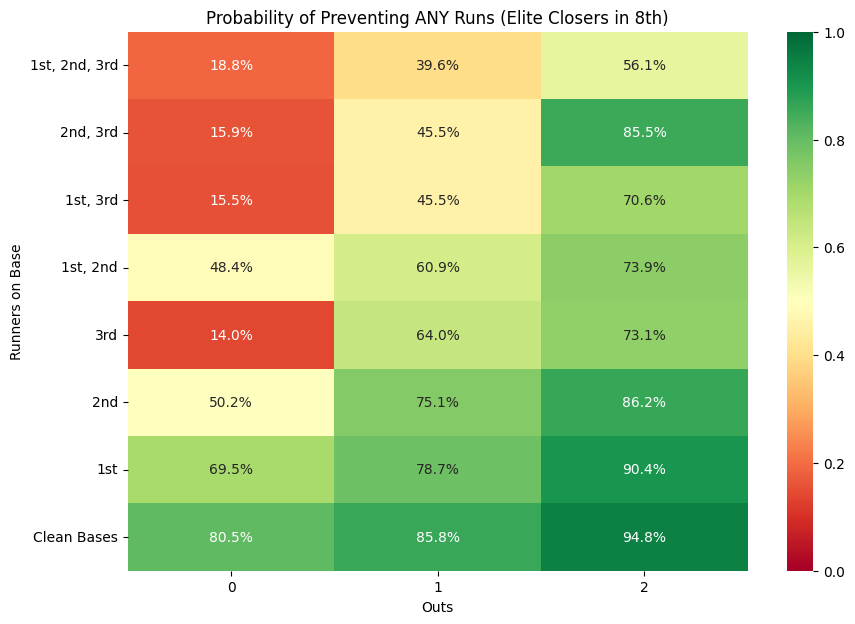

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 模擬情境：8局下，領先 1 分
scenarios = []
for on_1b in [0, 1]:
    for on_2b in [0, 1]:
        for on_3b in [0, 1]:
            for outs in [0, 1, 2]:
                scenarios.append({
                    'inning': 8,
                    'outs_when_up': outs,
                    'on_1b': on_1b,
                    'on_2b': on_2b,
                    'on_3b': on_3b,
                    'score_differential': 1
                })

df_scenarios = pd.DataFrame(scenarios)

# 預測「守住不失分」的機率
probs = rf_model_runs.predict_proba(df_scenarios)
df_scenarios['prevention_prob'] = probs[:, 1] # Probability of Class 1 (No Runs Scored)

# 標籤化
def get_runner_state(row):
    bases = []
    if row['on_1b']: bases.append("1st")
    if row['on_2b']: bases.append("2nd")
    if row['on_3b']: bases.append("3rd")
    return ", ".join(bases) if bases else "Clean Bases"

df_scenarios['runner_state'] = df_scenarios.apply(get_runner_state, axis=1)

# 畫圖
heatmap_data = df_scenarios.pivot(index='runner_state', columns='outs_when_up', values='prevention_prob')
runner_order = ['1st, 2nd, 3rd', '2nd, 3rd', '1st, 3rd', '1st, 2nd', '3rd', '2nd', '1st', 'Clean Bases']
heatmap_data = heatmap_data.reindex(runner_order)

plt.figure(figsize=(10, 7))
# 注意：這次的顏色範圍 (vmin) 可以拉低一點，因為滿壘不失分很難
sns.heatmap(heatmap_data, annot=True, fmt=".1%", cmap="RdYlGn", vmin=0.0, vmax=1.0)
plt.title("Probability of Preventing ANY Runs (Elite Closers in 8th)")
plt.ylabel("Runners on Base")
plt.xlabel("Outs")
plt.show()

In [ ]:
import pandas as pd
from pybaseball import pitching_stats, playerid_lookup, statcast_pitcher
import time

# 1. 找出 2024 年「表現最差」的常規終結者
# 條件：至少 10 次救援成功 (確保他是 Closer)，但 ERA 很高
print("Fetching Bottom Closer list...")
stats_2024 = pitching_stats(2024, qual=30)
bad_closers = stats_2024[stats_2024['SV'] >= 10].sort_values('ERA', ascending=False).head(10)

print("Bottom 5 Closers (High ERA):")
print(bad_closers[['Name', 'SV', 'ERA', 'Team']])

# 2. 抓取他們的投球數據 (2023-2025)
bad_data = []

for index, row in bad_closers.iterrows():
    name = row['Name']
    print(f"Fetching data for: {name} (ERA: {row['ERA']})...")

    try:
        first, last = name.split(' ', 1)
        player_ids = playerid_lookup(last, first)

        if not player_ids.empty:
            mlb_id = player_ids['key_mlbam'].values[0]
            player_data = statcast_pitcher('2023-04-01', '2025-10-01', player_id=mlb_id)
            player_data['pitcher_name'] = name
            bad_data.append(player_data)
        else:
            print(f"Could not find ID for {name}")

    except Exception as e:
        print(f"Error fetching {name}: {e}")

    time.sleep(1.5)

if bad_data:
    df_bad = pd.concat(bad_data)
    print(f"Total 'Bad Closer' Pitches: {len(df_bad)}")

Fetching Bottom Closer list...
Bottom 5 Closers (High ERA):
                     Name  SV   ERA   Team
440          Tyler Kinley  12  6.19    COL
428          David Bednar  23  5.77    PIT
404         Craig Kimbrel  23  5.33    BAL
370        James McArthur  18  4.92    KCR
364          Camilo Doval  23  4.88    SFG
326           Jalen Beeks  10  4.50  - - -
314  Seranthony Dominguez  11  4.45  - - -
295           Paul Sewald  16  4.31    ARI
267          Hector Neris  18  4.10  - - -
265         Jose Alvarado  13  4.09    PHI
Fetching data for: Tyler Kinley (ERA: 6.19)...
Gathering Player Data
Fetching data for: David Bednar (ERA: 5.77)...
Gathering Player Data
Fetching data for: Craig Kimbrel (ERA: 5.33)...
Gathering Player Data
Fetching data for: James McArthur (ERA: 4.92)...
Gathering Player Data
Fetching data for: Camilo Doval (ERA: 4.88)...
Gathering Player Data
Fetching data for: Jalen Beeks (ERA: 4.5)...
Gathering Player Data
Fetching data for: Seranthony Dominguez (ERA: 4.45).

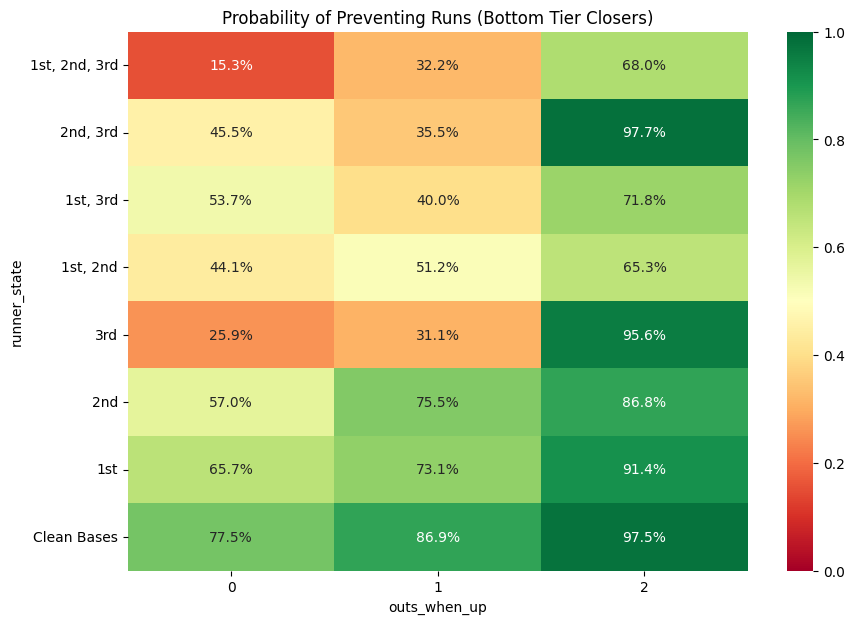

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# --- 1. 資料處理 (針對後段班數據) ---
data = df_bad.copy() # 使用後段班數據

# 轉換跑者 & 計算分數差
data['on_1b'] = data['on_1b'].fillna(0).apply(lambda x: 1 if x > 0 else 0)
data['on_2b'] = data['on_2b'].fillna(0).apply(lambda x: 1 if x > 0 else 0)
data['on_3b'] = data['on_3b'].fillna(0).apply(lambda x: 1 if x > 0 else 0)
data['score_differential'] = data['fld_score'] - data['bat_score']

# 計算 Run Expectancy Target (是否守住不失分)
data = data.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'])
inning_end_scores = data.groupby(['game_pk', 'inning', 'inning_topbot'])['post_bat_score'].transform('max')
data['runs_rest_of_inning'] = inning_end_scores - data['bat_score']
data['is_fireman_success'] = data['runs_rest_of_inning'].apply(lambda x: 1 if x == 0 else 0)

# 取每個打席的第一球
df_ab_bad = data.drop_duplicates(subset=['game_pk', 'inning', 'at_bat_number'], keep='first')

# --- 2. 訓練 Random Forest ---
X_bad = df_ab_bad[['inning', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b', 'score_differential']]
y_bad = df_ab_bad['is_fireman_success']

rf_model_bad = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model_bad.fit(X_bad, y_bad)

# --- 3. 生成 Heatmap ---
# 建立情境 (8局, 領先1分)
scenarios = []
for on_1b in [0, 1]:
    for on_2b in [0, 1]:
        for on_3b in [0, 1]:
            for outs in [0, 1, 2]:
                scenarios.append({
                    'inning': 8,
                    'outs_when_up': outs,
                    'on_1b': on_1b,
                    'on_2b': on_2b,
                    'on_3b': on_3b,
                    'score_differential': 1
                })

df_scenarios_bad = pd.DataFrame(scenarios)
probs_bad = rf_model_bad.predict_proba(df_scenarios_bad)
df_scenarios_bad['prevention_prob'] = probs_bad[:, 1]

# 標籤化
def get_runner_state(row):
    bases = []
    if row['on_1b']: bases.append("1st")
    if row['on_2b']: bases.append("2nd")
    if row['on_3b']: bases.append("3rd")
    return ", ".join(bases) if bases else "Clean Bases"

df_scenarios_bad['runner_state'] = df_scenarios_bad.apply(get_runner_state, axis=1)

# 畫圖
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_bad = df_scenarios_bad.pivot(index='runner_state', columns='outs_when_up', values='prevention_prob')
runner_order = ['1st, 2nd, 3rd', '2nd, 3rd', '1st, 3rd', '1st, 2nd', '3rd', '2nd', '1st', 'Clean Bases']
heatmap_bad = heatmap_bad.reindex(runner_order)

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_bad, annot=True, fmt=".1%", cmap="RdYlGn", vmin=0.0, vmax=1.0)
plt.title("Probability of Preventing Runs (Bottom Tier Closers)")
plt.show()

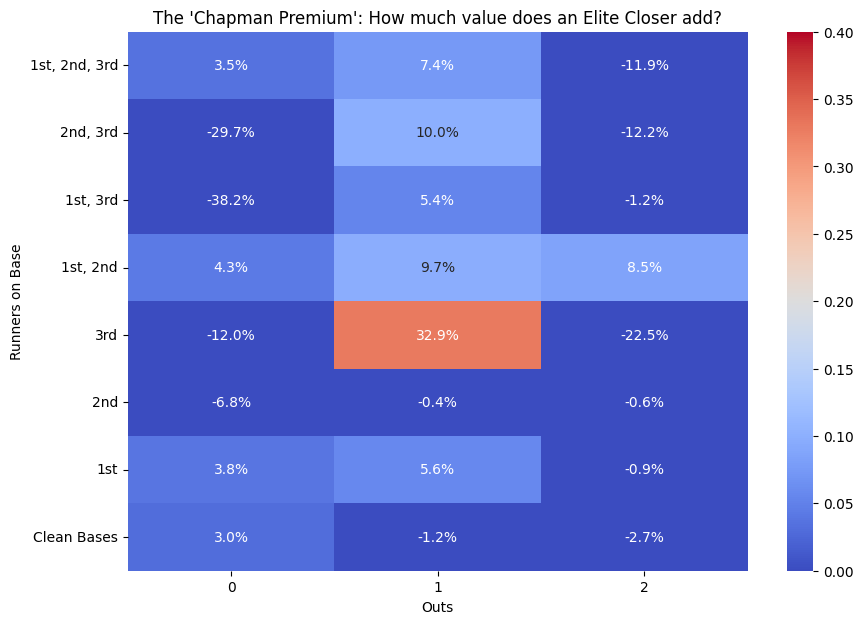

In [ ]:
# 假設你之前的 Elite 結果存在 'heatmap_data' (請確保變數名稱正確，或者重新跑一次上面的 elite 預測存起來)
# 這裡假設 heatmap_elite 是你上一張圖的數據 DataFrame

# 計算差異 (Elite - Bad)
heatmap_diff = heatmap_data - heatmap_bad

plt.figure(figsize=(10, 7))
# 使用 Coolwarm 配色：紅色代表沒差別(0)，藍色代表差別巨大
sns.heatmap(heatmap_diff, annot=True, fmt=".1%", cmap="coolwarm", vmin=0, vmax=0.4)
plt.title("The 'Chapman Premium': How much value does an Elite Closer add?")
plt.ylabel("Runners on Base")
plt.xlabel("Outs")
plt.show()